## Test on a simple case
Consider the following Possion Equation
$$
\begin{cases}
    -\Delta u = 1\qquad &u\in\Omega\\
    u(x) = 0\qquad &u\in\partial\Omega.
\end{cases}$$
Here $\Omega = (-1,1)\times(-1,1)\backslash[0,1)\times\{0\}$


In [28]:
% matplotlib inline
import torch 
import torch.nn.functional as F
import numpy as np
from math import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm

torch.set_default_tensor_type('torch.FloatTensor')

m = 10
learning_rate = 0.01
iterations = 400  #default 10000
print_every_iter = 100
beta = 5 #coefficient for the regularization term in the loss expression, is set to be 1000 in section 3.1
n1 = 1000 #number of points in (0,1)^m
n2 = 100  #number of points on the border of (0,1)^m
n3 = 100  #number of points used for evaluating the error

#用DeepRitzNet模拟论文中的 -u
class DeepRitzNet(torch.nn.Module):
    def __init__(self, m):
        super(DeepRitzNet, self).__init__()
        self.linear1 = torch.nn.Linear(m,m)
        self.linear2 = torch.nn.Linear(m,m)
        self.linear3 = torch.nn.Linear(m,m)
        self.linear4 = torch.nn.Linear(m,m)
        self.linear5 = torch.nn.Linear(m,m)
        self.linear6 = torch.nn.Linear(m,m)
        
        self.linear7 = torch.nn.Linear(m,1)
        
        
        
    def forward(self, x):
        y = x
        y = y + F.relu(self.linear2(F.relu(self.linear1(y))))
        y = y + F.relu(self.linear4(F.relu(self.linear3(y))))
        y = y + F.relu(self.linear6(F.relu(self.linear5(y))))
        output = F.relu(self.linear7(y))
        return output

In [29]:
def draw_graph():
    points = np.arange(-1, 1, 0.01)
    xs, ys = np.meshgrid(points, points)
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    xl, yl = xs.size()
    z = np.zeros((xl, yl))
    for i in range(xl):
        for j in range(yl):      
            re = np.zeros(m)
            re[0] = xs[i, j]
            re[1] = ys[i, j]
            re = torch.tensor(re)        
            z[i, j] = model(re.float()).item() #- U_groundtruth(re)
            #z[i, j] =  U_groundtruth(re)
    
    plt.imshow(z, cmap=cm.hot)
    plt.colorbar()
    
    #plt.savefig("loss_1.eps")
    plt.show()

In [30]:
def cal_loss():
    points = np.arange(-1, 1.1, 0.1)
    xs, ys = np.meshgrid(points, points)
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    xl, yl = xs.size()
    z = np.zeros((xl, yl))
    mmm = 0
    for i in np.arange(1, xl):
        for j in np.arange(1, yl):      
            re = np.zeros(m)
            re[0] = xs[i, j]
            re[1] = ys[i, j]
            #not on border
            if (i<xl/2 or j != yl/2+1):
                re = torch.tensor(re)        
                z[i, j] = (model(re.float()).item() - U_groundtruth(re))#/ U_groundtruth(re)
                if abs(z[i, j]) > mmm:
                    mmm += abs(z[i, j])
    
    return mmm / (xl * yl)

In [31]:
#U_groundtruth (r, theta) = sqrt(r) * sin(theta/2)
#take in a (m,) tensor (x, y, ...)
def U_groundtruth(t):
    theta = atan2(t[1].item(), t[0].item()) #+ 2*pi #-pi < atan(·) < pi
    re = sqrt(sqrt((t[0] ** 2 + t[1] ** 2).item())) * sin(theta/2)
    return re

In [32]:
"""
Train with the grid
对权重初始化有高度依赖性
"""

model = DeepRitzNet(m)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
in_error_iter = [] #record the error in Omega every print_every_iter=100 times
on_error_iter = [] #record the error on the border of Omega every print_every_iter=100 times

mm = 500
points = np.arange(-1, 1.1, 0.1)
xs, ys = np.meshgrid(points, points)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
xl, yl = xs.size()

for k in range(10000):
    loss = torch.zeros(1)
    i1=0
    #x_input not on the border of \Omega
    for i in np.arange(1, xl):
        for j in np.arange(1, yl):        
            x_input = np.zeros(m)
            x_input[0] = xs[i, j]
            x_input[1] = ys[i, j]
            
            #if (x,y)is not on x-aris
            if (abs(x_input[1]) > 0.001 or x_input[0] < 0.001) : 
                x_input = torch.tensor(x_input).float()
                y = model(x_input)

                x1 = torch.zeros(m)
                x2 = torch.zeros(m)
                x1[0] = 0.0001
                x2[1] = 0.0001
                x_input_1 = x_input.float() + x1
                x_input_2 = x_input.float() + x2
                x_input_grad_1 = (model(x_input_1) - y) / 0.0001
                x_input_grad_2 = (model(x_input_2) - y) / 0.0001

                loss += 0.5 * ((x_input_grad_1) ** 2 + (x_input_grad_2) ** 2) - y.item()
                #loss += 0.5 * ((x_input.grad.float()[0]) ** 2 + (x_input.grad.float()[1]) ** 2) + y
                i1+=1
                
    #loss /= (xl * yl)
    loss/=i1
    
    regularization = torch.zeros(1)
    i2=0
    for i in range(xl):
        for j in range(yl): 
            if (i==0 or i==xl-1) or (j==0 or j==yl-1) or (i>=xl/2 and j==yl/2+1):
                x_input = np.zeros(m)
                x_input[0] = xs[i, j]
                x_input[1] = ys[i, j]           
                x_input = torch.tensor(x_input).float()
                y = model(x_input)
                regularization += y.item()**2 
                i2 += 1
    print("i1:",i1,"i2:",i2)
    regularization *= mm / i2
    #if mm < 500:
        #mm = mm * 1.05
        
    #print loss
    print(k, " epoch, loss: ", loss.data[0].numpy())
    print(k, " epoch, regularization loss: ", regularization.data[0].numpy())
    print(k, "epoch, loss + regularization: ", (loss+regularization).item())
    '''
    print(k, " loss to real solution: ", cal_loss())
    if cal_loss() < 0.0001:
        break
    '''
    loss += regularization
    
    #and step the optimizer
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

i1: 390 i2: 80
0  epoch, loss:  -0.0051231976
0  epoch, regularization loss:  2.201979
0 epoch, loss + regularization:  2.1968557834625244
i1: 390 i2: 80
1  epoch, loss:  -0.0013018325
1  epoch, regularization loss:  0.5860268
1 epoch, loss + regularization:  0.5847249627113342
i1: 390 i2: 80
2  epoch, loss:  -4.211321e-06
2  epoch, regularization loss:  0.09826857
2 epoch, loss + regularization:  0.09826435893774033
i1: 390 i2: 80
3  epoch, loss:  3.4417906e-05
3  epoch, regularization loss:  0.0024763509
3 epoch, loss + regularization:  0.0025107688270509243
i1: 390 i2: 80
4  epoch, loss:  0.0
4  epoch, regularization loss:  0.0
4 epoch, loss + regularization:  0.0
i1: 390 i2: 80
5  epoch, loss:  0.0
5  epoch, regularization loss:  0.0
5 epoch, loss + regularization:  0.0
i1: 390 i2: 80
6  epoch, loss:  0.0
6  epoch, regularization loss:  0.0
6 epoch, loss + regularization:  0.0
i1: 390 i2: 80
7  epoch, loss:  0.0
7  epoch, regularization loss:  0.0
7 epoch, loss + regularization:  0

KeyboardInterrupt: 

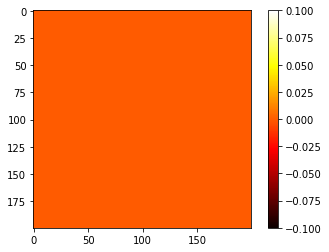

In [27]:
draw_graph()

In [ ]:
# Calculate time for grid method
start = time.time()
for k in range(10):
    loss = torch.zeros(1)
    for i in range(xl):
        for j in range(yl):        
            x_input = np.zeros(m)
            x_input[0] = xs[i, j]
            x_input[1] = ys[i, j]
            if x_input[0] ** 2 + x_input[1] ** 2 < 1:
                x_input = torch.tensor(x_input).float()
                y = model(x_input)
                
                x1 = torch.zeros(m)
                x2 = torch.zeros(m)
                x1[0] = 0.0001
                x2[1] = 0.0001
                x_input_1 = x_input.float() + x1
                x_input_2 = x_input.float() + x2
                x_input_grad_1 = (model(x_input_1) - y) / 0.0001
                x_input_grad_2 = (model(x_input_2) - y) / 0.0001

                loss += 0.5 * ((x_input_grad_1) ** 2 + (x_input_grad_2) ** 2) - y
                #loss += 0.5 * ((x_input.grad.float()[0]) ** 2 + (x_input.grad.float()[1]) ** 2) + y
                
    loss /= (xl * yl)
    
    regularization = torch.zeros(1)
    for t in range(n2):
        theta = t / n2 * (2 * pi)
        x_input = np.zeros(m)
        x_input[0] = cos(theta)
        x_input[1] = sin(theta)
        x_input = torch.tensor(x_input).float()
        y = model(x_input)
        regularization += y**2 
    regularization *= mm / n2
    if mm < 500:
        mm = mm * 1.01
        
    #print loss
    print(k, " epoch, loss: ", loss.data[0].numpy())
    print(k, " epoch, regularization loss: ", regularization.data[0].numpy())
    print(k, " loss to real solution: ", cal_loss())
    if cal_loss() < 0.0001:
        break
    
    loss += regularization
    
    #and step the optimizer
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
stop = time.time()
print(stop - start)